In [ ]:
import numpy as np
import tensorflow
from sklearn.metrics import accuracy_score
#from tensorflow import set_random_seed
from keras.models import load_model
from keras.layers import Input, Embedding, LSTM, Dense,Concatenate,Lambda
from keras.models import Model
import keras
from keras import backend as K
from keras.layers import Dense, Activation, Flatten,TimeDistributed,Dropout,Bidirectional
from keras.layers import RepeatVector,merge,Permute,GlobalMaxPool1D
#from attention_utils import get_activations, get_data_recurrent
from keras.callbacks import EarlyStopping
import _pickle as cPickle
np.random.seed(123)
tensorflow.random.set_seed(2)
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import requests

In [ ]:
# !ls "/content/drive/"
from google.colab import drive
drive.mount('/content/drive')
df_newfile=pd.read_csv("/content/drive/MyDrive/phase_number.csv")
df_newfile=df_newfile[['Country'	,'Slow'	,'Moderate',	'Fast']]
df_newfile


Mounted at /content/drive


,Country,Slow,Moderate,Fast
0,Afghanistan,0,2,1
1,Albania,0,1,2
2,Algeria,0,1,2
3,Andorra,1,0,2
4,Angola,0,2,1
...,...,...,...,...
176,Venezuela,2,1,0
177,Vietnam,1,2,0
178,Yemen,1,0,2
179,Zambia,1,2,0


In [ ]:
# create an Empty DataFrame
df = pd.DataFrame(columns = [ 'Date', 'Confirmed Cases','Daily Cases','Country'])
for ind in df_newfile.index:
  countryname=df_newfile['Country'][ind]
  moderatephase=df_newfile['Moderate'][ind]
  
  try:
      dfmoderate = pd.read_csv(
          '/content/drive/MyDrive/CountriesSplitted3Phases/' + countryname + '.csv_split' + str(moderatephase) + '.csv')
      dfmoderate['CountryName'] = countryname
      dfmoderate['Daily Cases'] = dfmoderate['Confirmed Cases'].diff().fillna(0)
      if (len(dfmoderate) > 0):
          # now we add this to Train data set
          for ind2 in dfmoderate.index:
              df = df.append({'Date': dfmoderate['Date'][ind2], 'Confirmed Cases': dfmoderate['Confirmed Cases'][ind2],
                              'Daily Cases': dfmoderate['Daily Cases'][ind2], 'Country': countryname},
                             ignore_index=True)
  except:
      print("some error")
      continue;


some error


In [ ]:
mask = (df['Date'] < 20201101)
df_train=df.loc[mask].reset_index(drop=True)
mask1 = ((df['Date'] >= 20201101) & (df['Date'] < 20201118))
df_test=df.loc[mask1].reset_index(drop=True)


In [ ]:
df_train

,Date,Confirmed Cases,Daily Cases,Country
0,20200710,34184.0,0.0,Afghanistan
1,20200711,34356.0,172.0,Afghanistan
2,20200712,34441.0,85.0,Afghanistan
3,20200713,34595.0,154.0,Afghanistan
4,20200714,34730.0,135.0,Afghanistan
...,...,...,...,...
28735,20201027,8315.0,12.0,Zimbabwe
28736,20201028,8320.0,5.0,Zimbabwe
28737,20201029,8349.0,29.0,Zimbabwe
28738,20201030,8362.0,13.0,Zimbabwe


In [ ]:
X_train=[]
Y_train=[]

#now we divide df_train to X_train and Y_train

#for every country in df_newfile
for ind in df_newfile.index:
  countryname=df_newfile['Country'][ind]
  
  # for ind2 in dfslow.index:
  df_g=df_train[df_train['Country']==countryname]
  df_g = df_g[df_g['Daily Cases']>0]
  df_g=df_g['Daily Cases']
  data=df_g.values
  # print(data.shape)
  for i in range(0,len(data)):
    if i+16<=len(data):
        X_train.append(data[i:i+10])
        Y_train.append(data[i+9:i+16])
    
X_train=np.array(X_train)
Y_train=np.array(Y_train)
print(len(X_train))
print(len(Y_train))
X_train

18598
18598


array([[172.,  85., 154., ...,  60., 174.,  40.],
       [ 85., 154., 135., ..., 174.,  40., 112.],
       [154., 135., 254., ...,  40., 112., 112.],
       ...,
       [ 19.,  20.,  24., ...,  28.,  27.,  15.],
       [ 20.,  24.,  11., ...,  27.,  15.,  12.],
       [ 24.,  11.,  37., ...,  15.,  12.,   7.]])

In [ ]:
#sample
X_train[15:25]

array([[121., 106., 105., 105.,  69., 133.,  35.,   1.,  36.,  36.],
       [106., 105., 105.,  69., 133.,  35.,   1.,  36.,  36.,  47.],
       [105., 105.,  69., 133.,  35.,   1.,  36.,  36.,  47., 108.],
       [105.,  69., 133.,  35.,   1.,  36.,  36.,  47., 108.,  78.],
       [ 69., 133.,  35.,   1.,  36.,  36.,  47., 108.,  78.,  40.],
       [133.,  35.,   1.,  36.,  36.,  47., 108.,  78.,  40.,  37.],
       [ 35.,   1.,  36.,  36.,  47., 108.,  78.,  40.,  37.,  70.],
       [  1.,  36.,  36.,  47., 108.,  78.,  40.,  37.,  70., 107.],
       [ 36.,  36.,  47., 108.,  78.,  40.,  37.,  70., 107.,  76.],
       [ 36.,  47., 108.,  78.,  40.,  37.,  70., 107.,  76.,  86.]])

In [ ]:
#sample
Y_train

array([[ 40., 112., 112., ...,  60.,  48., 121.],
       [112., 112., 201., ...,  48., 121., 106.],
       [112., 201.,  60., ..., 121., 106., 105.],
       ...,
       [ 15.,  12.,   7., ...,  12.,   5.,  29.],
       [ 12.,   7.,  27., ...,   5.,  29.,  13.],
       [  7.,  27.,  12., ...,  29.,  13.,   5.]])

In [ ]:
X_traintemp=X_train#temporary 
Y_traintemp=Y_train#temporary not in use

In [ ]:
X_train=X_train.reshape((len(X_train),10,1))
print(X_train.shape,Y_train.shape)

(18598, 10, 1) (18598, 7)


In [ ]:
# LSTM architecture
def model_arch():
    lstm_hidden = 32
    initi = keras.initializers.RandomNormal(mean=0.0, stddev=0.01, seed=123)
    main_input = Input(shape=(10,1), name='main_input')
    lstm_out = LSTM(lstm_hidden,kernel_initializer=initi, recurrent_initializer= initi, bias_initializer=initi)(main_input)
    lstm_out = Dropout(0.45)(lstm_out)
    main_output = (Dense(7, name='main_output')(lstm_out))
#     Adam=keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)

    model = Model(inputs=main_input, outputs=main_output)
    model.compile(loss='mean_squared_error',optimizer='adam')
    return model

model = model_arch()
earlystop=EarlyStopping(monitor='val_acc', min_delta=0, patience=4, verbose=0, mode='auto', baseline=None, restore_best_weights=True)
callbacks_list = [earlystop]
print("model is building")
bs = 128
model.fit(batch_size=bs,epochs=100,x=X_train,y=Y_train, verbose=1,validation_split=0.1)
print("model building done")
    

model is building
Epoch 1/100
131/131 [==============================] - 4s 13ms/step - loss: 6565936.5606 - val_loss: 2319419.7500
Epoch 2/100
131/131 [==============================] - 1s 7ms/step - loss: 6772023.4545 - val_loss: 2314025.0000
Epoch 3/100
131/131 [==============================] - 1s 7ms/step - loss: 5732725.0152 - val_loss: 2308787.2500
Epoch 4/100
131/131 [==============================] - 1s 7ms/step - loss: 6299686.8371 - val_loss: 2303684.0000
Epoch 5/100
131/131 [==============================] - 1s 8ms/step - loss: 6482024.4356 - val_loss: 2298634.2500
Epoch 6/100
131/131 [==============================] - 1s 7ms/step - loss: 6768309.5076 - val_loss: 2293703.7500
Epoch 7/100
131/131 [==============================] - 1s 7ms/step - loss: 6083557.2917 - val_loss: 2288785.7500
Epoch 8/100
131/131 [==============================] - 1s 7ms/step - loss: 6234864.7462 - val_loss: 2283937.7500
Epoch 9/100
131/131 [==============================] - 1s 7ms/step - loss: 59

In [ ]:
# Prepare test data
X_test=[]
Y_test=[]
for ind in df_newfile.Country:
  df_g=df_test[df_test['Country']==ind]
  df_g = df_g[df_g['Daily Cases']!=0]
  df_g=df_g['Daily Cases']
  data=df_g.values
  for i in range(0,len(data)):
        if i+16<=len(data):
            X_test.append(data[i:i+10])
            Y_test.append(data[i+9:i+16])
X_test=np.array(X_test)
Y_test=np.array(Y_test)
print(len(X_test),len(Y_test))

981 981


In [ ]:
X_test

array([[ 76., 132.,  95., ..., 126., 138., 166.],
       [132.,  95.,  86., ..., 138., 166., 146.],
       [230., 193., 349., ...,  98., 247., 136.],
       ...,
       [ 16.,  31.,  49., ...,  46.,  60.,  80.],
       [  7.,  15.,  21., ...,  33.,  30.,  49.],
       [ 15.,  21.,  17., ...,  30.,  49.,  57.]])

In [ ]:
Y_test

array([[166., 146., 186., ...,  66., 205., 228.],
       [146., 186., 174., ..., 205., 228., 213.],
       [136., 137., 100., ..., 146.,  77., 164.],
       ...,
       [ 80.,  95.,  88., ...,  73.,  74., 104.],
       [ 49.,  57.,  29., ...,  21.,  43.,  68.],
       [ 57.,  29.,  69., ...,  43.,  68.,  48.]])

In [ ]:
np.savetxt('/content/xtrain_m.txt', X_test, fmt='%d')
np.savetxt('/content/ytrain_m.txt', Y_test, fmt='%d')

In [ ]:
# X_testtempp=X_test
# X_test= scaler.transform(X_test)
X_test=X_test.reshape((len(X_test),10,1))
print(X_test.shape,Y_test.shape)

(981, 10, 1) (981, 7)


In [ ]:
# prediction
pred=model.predict(x=X_test)
print(pred.shape)
#inverse scaling
# pred1=scaler.inverse_transform(pred)

#Find RMSE
from sklearn.metrics import mean_squared_error

rms = mean_squared_error(Y_test, pred)
print(np.sqrt(rms))
#basic lstm rmse 3820.249039420963//don't remove


(981, 7)
4638.500867919959


In [ ]:
# dff = pd.DataFrame({'X':pred1, 'Y':Y_test})
# dff
# x = np.random.randn(5)
# y = np.sin(x)
# mg = pd.DataFrame({'x':pred1, 'y':Y_test})
pred[0:6]

array([[132.80963, 133.05873, 134.91261, 134.42543, 134.8692 , 135.04282,
        135.23112],
       [151.38934, 151.66614, 153.31186, 153.19165, 153.37102, 153.71048,
        153.59775],
       [141.4715 , 141.92148, 144.44458, 144.05502, 144.26128, 144.55212,
        144.65117],
       [145.1368 , 145.5776 , 148.19214, 147.69139, 148.04662, 148.29617,
        148.33228],
       [396.35532, 396.10443, 398.8032 , 397.61707, 399.14023, 401.07925,
        398.49564],
       [396.35532, 396.10443, 398.8032 , 397.61707, 399.14023, 401.07925,
        398.49564]], dtype=float32)

In [ ]:
Y_test[0:6]

array([[  166.,   146.,   186.,   174.,    66.,   205.,   228.],
       [  146.,   186.,   174.,    66.,   205.,   228.,   213.],
       [  136.,   137.,   100.,   175.,   146.,    77.,   164.],
       [  137.,   100.,   175.,   146.,    77.,   164.,   203.],
       [11977., 10880., 11163., 11859.,  8468.,  5645.,  7893.],
       [10880., 11163., 11859.,  8468.,  5645.,  7893., 10621.]])

In [ ]:
predbasic = np.loadtxt('predbasic.txt', dtype=float)

In [ ]:
predbasic.shape


(15, 7)

In [ ]:
import matplotlib.pyplot as plt


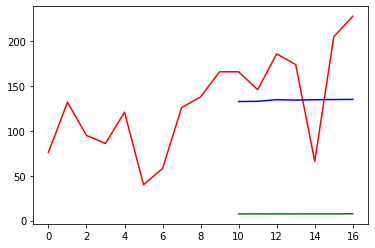

In [ ]:
x_value=[]
for ind in range(X_test.shape[1]+len(pred[0])):
  x_value.append(ind)
x_value
full=X_test[0]
full=full.reshape(X_test.shape[1])
full=np.append(full,Y_test[0])
# full.append(Y_test[0])
# full.shape
# for ind in Y_test[0]:
#   full.append(ind)
full



plt.plot(x_value,full, c='red')
x1_value=[]
for ind in range(len(pred[0])):
  x1_value.append(ind+X_test.shape[1])
x1_value
plt.plot(x1_value,pred[0], c='blue')


x2_value=[]
for ind in range(len(predbasic[0])):
  x2_value.append(ind+X_test.shape[1])
x2_value
plt.plot(x2_value,predbasic[0], c='green')


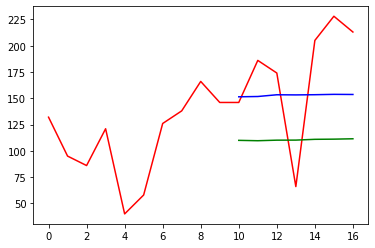

In [ ]:
x_value=[]
for ind in range(X_test.shape[1]+len(pred[0])):
  x_value.append(ind)
x_value
full=X_test[1]
full=full.reshape(X_test.shape[1])
full=np.append(full,Y_test[1])



plt.plot(x_value,full, c='red')
x1_value=[]
for ind in range(len(pred[1])):
  x1_value.append(ind+X_test.shape[1])
x1_value
plt.plot(x1_value,pred[1], c='blue')


x2_value=[]
for ind in range(len(predbasic[1])):
  x2_value.append(ind+X_test.shape[1])
x2_value
plt.plot(x2_value,predbasic[1], c='green')


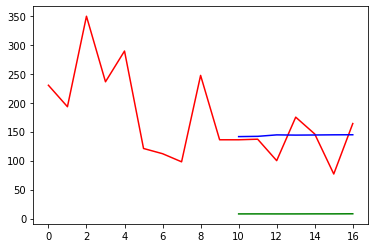

In [ ]:
x_value=[]
for ind in range(X_test.shape[1]+len(pred[0])):
  x_value.append(ind)
x_value
full=X_test[2]
full=full.reshape(X_test.shape[1])
full=np.append(full,Y_test[2])

plt.plot(x_value,full, c='red')
x1_value=[]
for ind in range(len(pred[2])):
  x1_value.append(ind+X_test.shape[1])
x1_value
plt.plot(x1_value,pred[2], c='blue')
x2_value=[]
for ind in range(len(predbasic[2])):
  x2_value.append(ind+X_test.shape[1])
x2_value
plt.plot(x2_value,predbasic[2], c='green')


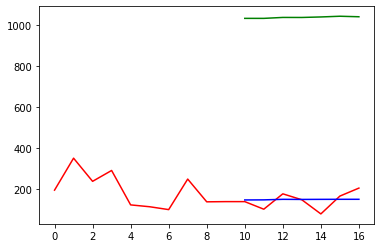

In [ ]:
x_value=[]
for ind in range(X_test.shape[1]+len(pred[3])):
  x_value.append(ind)
x_value
full=X_test[3]
full=full.reshape(X_test.shape[1])
full=np.append(full,Y_test[3])

plt.plot(x_value,full, c='red')
x1_value=[]
for ind in range(len(pred[3])):
  x1_value.append(ind+X_test.shape[1])
x1_value
plt.plot(x1_value,pred[3], c='blue')


x2_value=[]
for ind in range(len(predbasic[3])):
  x2_value.append(ind+X_test.shape[1])
x2_value
plt.plot(x2_value,predbasic[3], c='green')


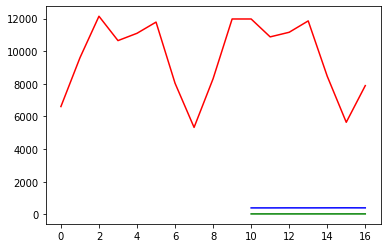

In [ ]:
x_value=[]
for ind in range(X_test.shape[1]+len(pred[4])):
  x_value.append(ind)
x_value
full=X_test[4]
full=full.reshape(X_test.shape[1])
full=np.append(full,Y_test[4])
# full.append(Y_test[0])
# full.shape
# for ind in Y_test[0]:
#   full.append(ind)
full
plt.plot(x_value,full, c='red')
x1_value=[]
for ind in range(len(pred[4])):
  x1_value.append(ind+X_test.shape[1])
x1_value
plt.plot(x1_value,pred[4], c='blue')


x2_value=[]
for ind in range(len(predbasic[4])):
  x2_value.append(ind+X_test.shape[1])
x2_value
plt.plot(x2_value,predbasic[4], c='green')


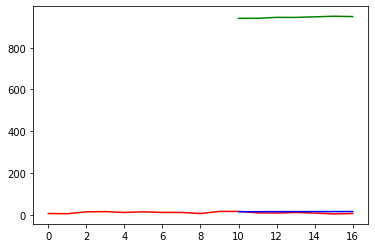

In [ ]:
x_value=[]
for ind in range(X_test.shape[1]+len(pred[6])):
  x_value.append(ind)
x_value
full=X_test[6]
full=full.reshape(X_test.shape[1])
full=np.append(full,Y_test[6])
# full.append(Y_test[0])
# full.shape
# for ind in Y_test[0]:
#   full.append(ind)
full



plt.plot(x_value,full, c='red')
x1_value=[]
for ind in range(len(pred[6])):
  x1_value.append(ind+X_test.shape[1])
x1_value
plt.plot(x1_value,pred[6], c='blue')


x2_value=[]
for ind in range(len(predbasic[6])):
  x2_value.append(ind+X_test.shape[1])
x2_value
plt.plot(x2_value,predbasic[6], c='green')


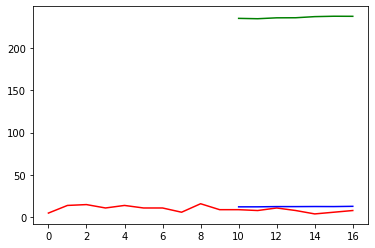

In [ ]:
x_value=[]
for ind in range(X_test.shape[1]+len(pred[7])):
  x_value.append(ind)
x_value
full=X_test[7]
full=full.reshape(X_test.shape[1])
full=np.append(full,Y_test[7])
# full.append(Y_test[0])
# full.shape
# for ind in Y_test[0]:
#   full.append(ind)
full



plt.plot(x_value,full, c='red')
x1_value=[]
for ind in range(len(pred[7])):
  x1_value.append(ind+X_test.shape[1])
x1_value
plt.plot(x1_value,pred[7], c='blue')


x2_value=[]
for ind in range(len(predbasic[7])):
  x2_value.append(ind+X_test.shape[1])
x2_value
plt.plot(x2_value,predbasic[7], c='green')


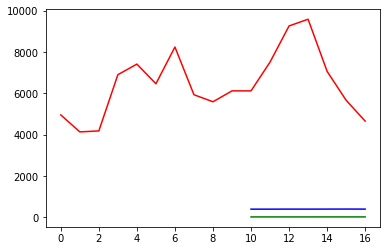

In [ ]:
x_value=[]
for ind in range(X_test.shape[1]+len(pred[8])):
  x_value.append(ind)
x_value
full=X_test[8]
full=full.reshape(X_test.shape[1])
full=np.append(full,Y_test[8])
# full.append(Y_test[0])
# full.shape
# for ind in Y_test[0]:
#   full.append(ind)
full



plt.plot(x_value,full, c='red')
x1_value=[]
for ind in range(len(pred[8])):
  x1_value.append(ind+X_test.shape[1])
x1_value
plt.plot(x1_value,pred[8], c='blue')


x2_value=[]
for ind in range(len(predbasic[8])):
  x2_value.append(ind+X_test.shape[1])
x2_value
plt.plot(x2_value,predbasic[8], c='green')


IndexError: ignored

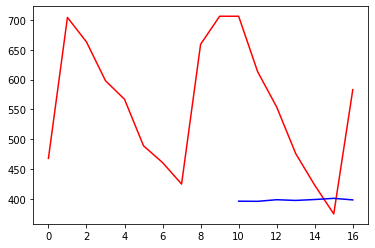

In [ ]:
x_value=[]
for ind in range(X_test.shape[1]+len(pred[100])):
  x_value.append(ind)
x_value
full=X_test[100]
full=full.reshape(X_test.shape[1])
full=np.append(full,Y_test[100])
# full.append(Y_test[0])
# full.shape
# for ind in Y_test[0]:
#   full.append(ind)
full



plt.plot(x_value,full, c='red')
x1_value=[]
for ind in range(len(pred[100])):
  x1_value.append(ind+X_test.shape[1])
x1_value
plt.plot(x1_value,pred[100], c='blue')


x2_value=[]
for ind in range(len(predbasic[100])):
  x2_value.append(ind+X_test.shape[1])
x2_value
plt.plot(x2_value,predbasic[100], c='green')


IndexError: ignored

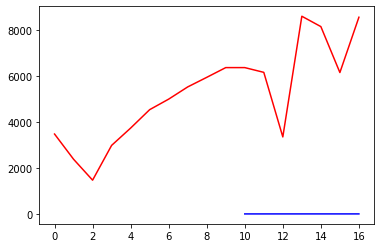

In [ ]:
x_value=[]
for ind in range(X_test.shape[1]+len(pred[200])):
  x_value.append(ind)
x_value
full=X_test[200]
full=full.reshape(X_test.shape[1])
full=np.append(full,Y_test[200])
# full.append(Y_test[0])
# full.shape
# for ind in Y_test[0]:
#   full.append(ind)
full



plt.plot(x_value,full, c='red')
x1_value=[]
for ind in range(len(pred[200])):
  x1_value.append(ind+X_test.shape[1])
x1_value
plt.plot(x1_value,pred[7], c='blue')


x2_value=[]
for ind in range(len(predbasic[200])):
  x2_value.append(ind+X_test.shape[1])
x2_value
plt.plot(x2_value,predbasic[200], c='green')


array([395.31503, 395.24   , 397.97446, 396.89337, 398.12067, 400.05106,
       397.2656 ], dtype=float32)

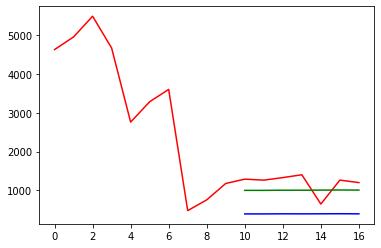

In [ ]:
x_value=[]
for ind in range(X_test.shape[1]+len(pred[300])):
  x_value.append(ind)
x_value
full=X_test[300]
full=full.reshape(X_test.shape[1])
full=np.append(full,Y_test[300])
# full.append(Y_test[0])
# full.shape
# for ind in Y_test[0]:
#   full.append(ind)
full



plt.plot(x_value,full, c='red')
x1_value=[]
for ind in range(len(pred[300])):
  x1_value.append(ind+X_test.shape[1])
x1_value
plt.plot(x1_value,pred[300], c='blue')


x2_value=[]
for ind in range(len(predbasic[300])):
  x2_value.append(ind+X_test.shape[1])
x2_value
plt.plot(x2_value,predbasic[300], c='green')
pred[300]

array([395.32013, 395.2451 , 397.97952, 396.89844, 398.12582, 400.05624,
       397.27072], dtype=float32)

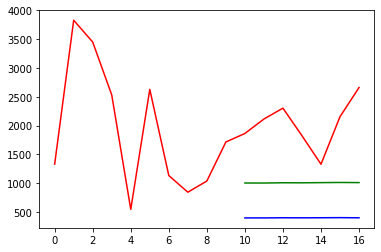

In [ ]:
x_value=[]
for ind in range(X_test.shape[1]+len(pred[400])):
  x_value.append(ind)
x_value
full=X_test[400]
full=full.reshape(X_test.shape[1])
full=np.append(full,Y_test[400])
# full.append(Y_test[0])
# full.shape
# for ind in Y_test[0]:
#   full.append(ind)
full



plt.plot(x_value,full, c='red')
x1_value=[]
for ind in range(len(pred[400])):
  x1_value.append(ind+X_test.shape[1])
x1_value
plt.plot(x1_value,pred[400], c='blue')


x2_value=[]
for ind in range(len(predbasic[400])):
  x2_value.append(ind+X_test.shape[1])
x2_value
plt.plot(x2_value,predbasic[400], c='green')
pred[400]
